In [10]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras 
import warnings
warnings.filterwarnings('ignore')
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense
from keras.layers import Conv2D,MaxPool2D,BatchNormalization,Dropout,Flatten
from keras import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
# import tensorflow.keras.optimizers.schedules.ExponentialDecay
from keras.callbacks import  ModelCheckpoint
import keras
from sklearn.metrics import classification_report,confusion_matrix
import os
from tensorflow.python.client import device_lib
import cv2
from keras.models import load_model
import matplotlib.pyplot as plt
import matplotlib as mpl
from keras.models import model_from_json

In [11]:
test_path = r'./dataset/chest_xray/test'
train_path = r'./dataset/chest_xray/train'
val_path = r'./dataset/chest_xray/val'
train_datagen = ImageDataGenerator( rotation_range=30,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    rescale=1./255)
test_val_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(train_path,target_size=(128,128),class_mode='binary',batch_size=32)
test_set = test_val_datagen.flow_from_directory(test_path,target_size=(128,128),class_mode='binary',batch_size=32)
val_set = test_val_datagen.flow_from_directory(val_path,target_size=(128,128),class_mode='binary',batch_size=32)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


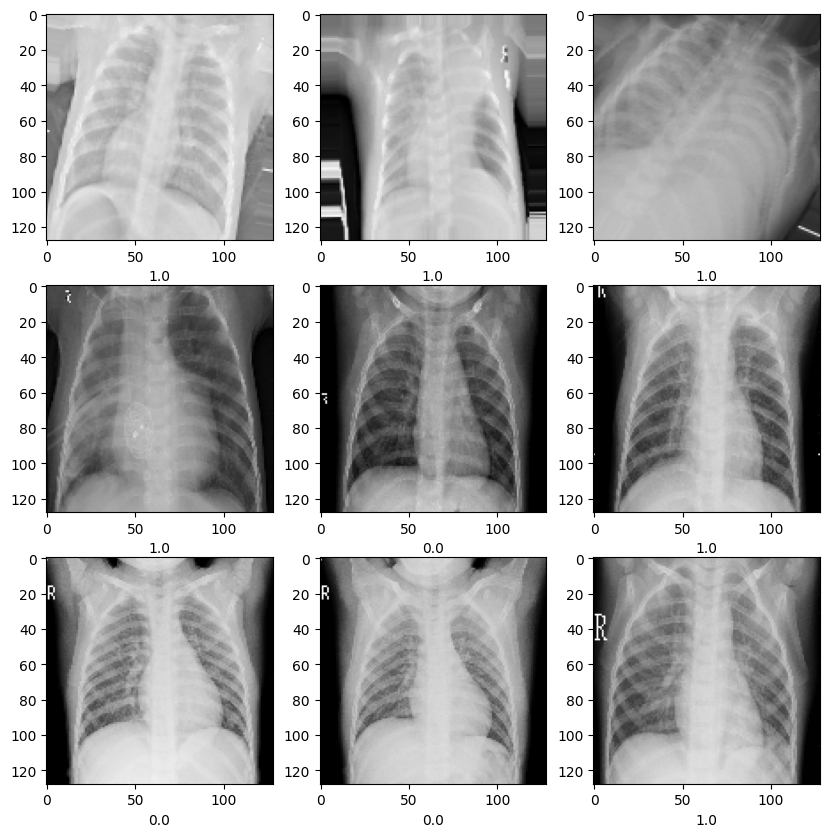

In [12]:
training_photos = training_set[0]
test_photos = test_set[0]
val_photos = val_set[0]
plt.subplots(3,3,figsize=(10,10))
for i in range(1,4):
    plt.subplot(3,3,i)
    plt.imshow(training_photos[0][i])
    plt.xlabel(training_photos[1][i])
for i in range(4,7):
    plt.subplot(3,3,i)
    plt.imshow(test_photos[0][i])
    plt.xlabel(test_photos[1][i])
for i in range(7,10):
    plt.subplot(3,3,i)
    plt.imshow(val_photos[0][i])
    plt.xlabel(val_photos[1][i])

In [13]:
COUNT_PNEUMONIA = 1342
COUNT_NORMAL = 3876
TOTAL = COUNT_NORMAL + COUNT_PNEUMONIA
weight_for_0 = (1 / COUNT_NORMAL) * (TOTAL) / 2.0
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TOTAL) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print("Weight for class 0: {:.2f}".format(weight_for_0))
print("Weight for class 1: {:.2f}".format(weight_for_1))

Weight for class 0: 0.67
Weight for class 1: 1.94


In [14]:
METRICS = [
        tf.keras.metrics.BinaryAccuracy(),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
    ]
checkpoint = ModelCheckpoint(r"E:\College\4th year 8th Sem\Project\pneumonia_Detection\Best weight\weight.h5", verbose=1, save_best_only=True)
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True)
#early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [15]:
model = Sequential()
model.add(Conv2D(16,(3,3),padding='Same',activation='relu',input_shape = (128,128,3)))
model.add(Conv2D(16,(3,3),activation='relu',padding='Same'))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv2D(32,(3,3),activation='relu',padding='Same'))
model.add(Conv2D(32,(3,3),activation='relu',padding='Same'))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv2D(64,(3,3),activation='relu',padding='Same'))
model.add(Conv2D(64,(3,3),activation='relu',padding='Same'))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv2D(64,(3,3),activation='relu',padding='Same'))
model.add(Conv2D(64,(3,3),activation='relu',padding='Same'))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.7))

model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(1 , activation = 'sigmoid'))
adam = Adam(learning_rate=lr_schedule,beta_1=0.9,beta_2=0.999,epsilon=1e-07)
model.compile(optimizer = adam,loss = 'binary_crossentropy' , metrics = METRICS) 

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 conv2d_9 (Conv2D)           (None, 128, 128, 16)      2320      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 batch_normalization_7 (Batc  (None, 64, 64, 16)       64        
 hNormalization)                                                 
                                                                 
 dropout_7 (Dropout)         (None, 64, 64, 16)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 64, 64, 32)       

In [17]:
STEPS_PER_EPOCH = 5
EPOCHS = 200

In [18]:
history = model.fit(training_set, 
                    validation_data = val_set ,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    callbacks=[checkpoint] ,
                    class_weight=class_weight,
                    epochs=EPOCHS)

Epoch 1/200
5/5 [==============================] - ETA: 0s - loss: 1.3689 - binary_accuracy: 0.5875 - precision: 0.7955 - recall: 0.5932
Epoch 1: val_loss improved from inf to 130.64081, saving model to E:\College\4th year 8th Sem\Project\pneumonia_Detection\Best weight\weight.h5
5/5 [==============================] - 12s 2s/step - loss: 1.3689 - binary_accuracy: 0.5875 - precision: 0.7955 - recall: 0.5932 - val_loss: 130.6408 - val_binary_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/200
5/5 [==============================] - ETA: 0s - loss: 1.1715 - binary_accuracy: 0.5562 - precision: 0.7255 - recall: 0.6325
Epoch 2: val_loss did not improve from 130.64081
5/5 [==============================] - 8s 2s/step - loss: 1.1715 - binary_accuracy: 0.5562 - precision: 0.7255 - recall: 0.6325 - val_loss: 576.8203 - val_binary_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 3/200
5/5 [==============================] - ETA: 0s - loss: 1.0714 - 

5/5 [==============================] - ETA: 0s - loss: 0.3101 - binary_accuracy: 0.8750 - precision: 0.8881 - recall: 0.9695
Epoch 20: val_loss did not improve from 3.93755
5/5 [==============================] - 7s 1s/step - loss: 0.3101 - binary_accuracy: 0.8750 - precision: 0.8881 - recall: 0.9695 - val_loss: 9.2843 - val_binary_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 21/200
5/5 [==============================] - ETA: 0s - loss: 0.4953 - binary_accuracy: 0.7625 - precision: 0.7518 - recall: 0.9626
Epoch 21: val_loss did not improve from 3.93755
5/5 [==============================] - 7s 1s/step - loss: 0.4953 - binary_accuracy: 0.7625 - precision: 0.7518 - recall: 0.9626 - val_loss: 10.5015 - val_binary_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 22/200
5/5 [==============================] - ETA: 0s - loss: 0.4152 - binary_accuracy: 0.8250 - precision: 0.8099 - recall: 0.9914
Epoch 22: val_loss did not improve from 3.93755
5/5 [=====

5/5 [==============================] - 8s 2s/step - loss: 0.3134 - binary_accuracy: 0.8625 - precision: 0.8592 - recall: 0.9839 - val_loss: 0.8905 - val_binary_accuracy: 0.5625 - val_precision: 1.0000 - val_recall: 0.1250
Epoch 40/200
5/5 [==============================] - ETA: 0s - loss: 0.2999 - binary_accuracy: 0.8875 - precision: 0.8686 - recall: 1.0000
Epoch 40: val_loss did not improve from 0.89055
5/5 [==============================] - 9s 2s/step - loss: 0.2999 - binary_accuracy: 0.8875 - precision: 0.8686 - recall: 1.0000 - val_loss: 0.9292 - val_binary_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 41/200
5/5 [==============================] - ETA: 0s - loss: 0.3071 - binary_accuracy: 0.8687 - precision: 0.8811 - recall: 0.9692
Epoch 41: val_loss did not improve from 0.89055
5/5 [==============================] - 8s 1s/step - loss: 0.3071 - binary_accuracy: 0.8687 - precision: 0.8811 - recall: 0.9692 - val_loss: 0.9836 - val_binary_accuracy: 0.5000

5/5 [==============================] - ETA: 0s - loss: 0.3170 - binary_accuracy: 0.8750 - precision: 0.8806 - recall: 0.9672
Epoch 59: val_loss did not improve from 0.56602
5/5 [==============================] - 8s 2s/step - loss: 0.3170 - binary_accuracy: 0.8750 - precision: 0.8806 - recall: 0.9672 - val_loss: 2.1609 - val_binary_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 60/200
5/5 [==============================] - ETA: 0s - loss: 0.3506 - binary_accuracy: 0.8375 - precision: 0.8561 - recall: 0.9520
Epoch 60: val_loss did not improve from 0.56602
5/5 [==============================] - 8s 2s/step - loss: 0.3506 - binary_accuracy: 0.8375 - precision: 0.8561 - recall: 0.9520 - val_loss: 1.9944 - val_binary_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 61/200
5/5 [==============================] - ETA: 0s - loss: 0.3204 - binary_accuracy: 0.7937 - precision: 0.7676 - recall: 1.0000
Epoch 61: val_loss did not improve from 0.56602
5/5 [======

5/5 [==============================] - ETA: 0s - loss: 0.3187 - binary_accuracy: 0.8938 - precision: 0.9098 - recall: 0.9487
Epoch 79: val_loss did not improve from 0.56602
5/5 [==============================] - 9s 2s/step - loss: 0.3187 - binary_accuracy: 0.8938 - precision: 0.9098 - recall: 0.9487 - val_loss: 1.7704 - val_binary_accuracy: 0.5625 - val_precision: 0.5333 - val_recall: 1.0000
Epoch 80/200
5/5 [==============================] - ETA: 0s - loss: 0.4425 - binary_accuracy: 0.8562 - precision: 0.8525 - recall: 0.9541
Epoch 80: val_loss did not improve from 0.56602
5/5 [==============================] - 8s 2s/step - loss: 0.4425 - binary_accuracy: 0.8562 - precision: 0.8525 - recall: 0.9541 - val_loss: 1.6109 - val_binary_accuracy: 0.5625 - val_precision: 0.5333 - val_recall: 1.0000
Epoch 81/200
5/5 [==============================] - ETA: 0s - loss: 0.2403 - binary_accuracy: 0.9000 - precision: 0.8947 - recall: 0.9835
Epoch 81: val_loss did not improve from 0.56602
5/5 [======

5/5 [==============================] - ETA: 0s - loss: 0.2334 - binary_accuracy: 0.9250 - precision: 0.9338 - recall: 0.9769
Epoch 99: val_loss did not improve from 0.56602
5/5 [==============================] - 7s 1s/step - loss: 0.2334 - binary_accuracy: 0.9250 - precision: 0.9338 - recall: 0.9769 - val_loss: 2.7826 - val_binary_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 100/200
5/5 [==============================] - ETA: 0s - loss: 0.2469 - binary_accuracy: 0.8313 - precision: 0.8201 - recall: 0.9828
Epoch 100: val_loss did not improve from 0.56602
5/5 [==============================] - 7s 1s/step - loss: 0.2469 - binary_accuracy: 0.8313 - precision: 0.8201 - recall: 0.9828 - val_loss: 2.7346 - val_binary_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 101/200
5/5 [==============================] - ETA: 0s - loss: 0.2197 - binary_accuracy: 0.8875 - precision: 0.8779 - recall: 0.9829
Epoch 101: val_loss did not improve from 0.56602
5/5 [==

5/5 [==============================] - ETA: 0s - loss: 0.2362 - binary_accuracy: 0.8938 - precision: 0.8790 - recall: 0.9820
Epoch 119: val_loss did not improve from 0.56602
5/5 [==============================] - 9s 2s/step - loss: 0.2362 - binary_accuracy: 0.8938 - precision: 0.8790 - recall: 0.9820 - val_loss: 2.7146 - val_binary_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 120/200
5/5 [==============================] - ETA: 0s - loss: 0.2223 - binary_accuracy: 0.9000 - precision: 0.8889 - recall: 0.9825
Epoch 120: val_loss did not improve from 0.56602
5/5 [==============================] - 8s 2s/step - loss: 0.2223 - binary_accuracy: 0.9000 - precision: 0.8889 - recall: 0.9825 - val_loss: 2.7515 - val_binary_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 121/200
5/5 [==============================] - ETA: 0s - loss: 0.1830 - binary_accuracy: 0.9312 - precision: 0.9339 - recall: 0.9741
Epoch 121: val_loss did not improve from 0.56602
5/5 [=

5/5 [==============================] - ETA: 0s - loss: 0.2437 - binary_accuracy: 0.9062 - precision: 0.9256 - recall: 0.9492
Epoch 139: val_loss did not improve from 0.56602
5/5 [==============================] - 8s 2s/step - loss: 0.2437 - binary_accuracy: 0.9062 - precision: 0.9256 - recall: 0.9492 - val_loss: 1.1741 - val_binary_accuracy: 0.5625 - val_precision: 0.6000 - val_recall: 0.3750
Epoch 140/200
5/5 [==============================] - ETA: 0s - loss: 0.1889 - binary_accuracy: 0.9187 - precision: 0.9297 - recall: 0.9675
Epoch 140: val_loss did not improve from 0.56602
5/5 [==============================] - 7s 1s/step - loss: 0.1889 - binary_accuracy: 0.9187 - precision: 0.9297 - recall: 0.9675 - val_loss: 0.8720 - val_binary_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.6250
Epoch 141/200
5/5 [==============================] - ETA: 0s - loss: 0.3190 - binary_accuracy: 0.8562 - precision: 0.8672 - recall: 0.9487
Epoch 141: val_loss did not improve from 0.56602
5/5 [=

5/5 [==============================] - ETA: 0s - loss: 0.3906 - binary_accuracy: 0.7750 - precision: 0.7465 - recall: 1.0000
Epoch 159: val_loss did not improve from 0.56602
5/5 [==============================] - 8s 2s/step - loss: 0.3906 - binary_accuracy: 0.7750 - precision: 0.7465 - recall: 1.0000 - val_loss: 1.4420 - val_binary_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 160/200
5/5 [==============================] - ETA: 0s - loss: 0.1570 - binary_accuracy: 0.9187 - precision: 0.9185 - recall: 0.9841
Epoch 160: val_loss did not improve from 0.56602
5/5 [==============================] - 7s 1s/step - loss: 0.1570 - binary_accuracy: 0.9187 - precision: 0.9185 - recall: 0.9841 - val_loss: 1.7068 - val_binary_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 161/200
5/5 [==============================] - ETA: 0s - loss: 0.1292 - binary_accuracy: 0.9625 - precision: 0.9600 - recall: 0.9917
Epoch 161: val_loss did not improve from 0.56602
5/5 [=

5/5 [==============================] - ETA: 0s - loss: 0.1944 - binary_accuracy: 0.9187 - precision: 0.9242 - recall: 0.9760
Epoch 179: val_loss did not improve from 0.56602
5/5 [==============================] - 7s 1s/step - loss: 0.1944 - binary_accuracy: 0.9187 - precision: 0.9242 - recall: 0.9760 - val_loss: 2.2071 - val_binary_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 180/200
5/5 [==============================] - ETA: 0s - loss: 0.1967 - binary_accuracy: 0.9125 - precision: 0.9185 - recall: 0.9764
Epoch 180: val_loss did not improve from 0.56602
5/5 [==============================] - 8s 1s/step - loss: 0.1967 - binary_accuracy: 0.9125 - precision: 0.9185 - recall: 0.9764 - val_loss: 3.1550 - val_binary_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 181/200
5/5 [==============================] - ETA: 0s - loss: 0.2251 - binary_accuracy: 0.8938 - precision: 0.8797 - recall: 0.9915
Epoch 181: val_loss did not improve from 0.56602
5/5 [=

5/5 [==============================] - ETA: 0s - loss: 0.2193 - binary_accuracy: 0.9062 - precision: 0.9134 - recall: 0.9667
Epoch 199: val_loss did not improve from 0.56602
5/5 [==============================] - 8s 2s/step - loss: 0.2193 - binary_accuracy: 0.9062 - precision: 0.9134 - recall: 0.9667 - val_loss: 2.3362 - val_binary_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 200/200
5/5 [==============================] - ETA: 0s - loss: 0.1727 - binary_accuracy: 0.9062 - precision: 0.8976 - recall: 0.9828
Epoch 200: val_loss did not improve from 0.56602
5/5 [==============================] - 8s 2s/step - loss: 0.1727 - binary_accuracy: 0.9062 - precision: 0.8976 - recall: 0.9828 - val_loss: 2.2106 - val_binary_accuracy: 0.5625 - val_precision: 0.5333 - val_recall: 1.0000


In [19]:
matrix = model.evaluate(test_set,return_dict=True,verbose=0)
for i,j in matrix.items():
    print(str(i)+' is '+str(j))

loss is 0.48418909311294556
binary_accuracy is 0.8653846383094788
precision is 0.832608699798584
recall is 0.9820512533187866


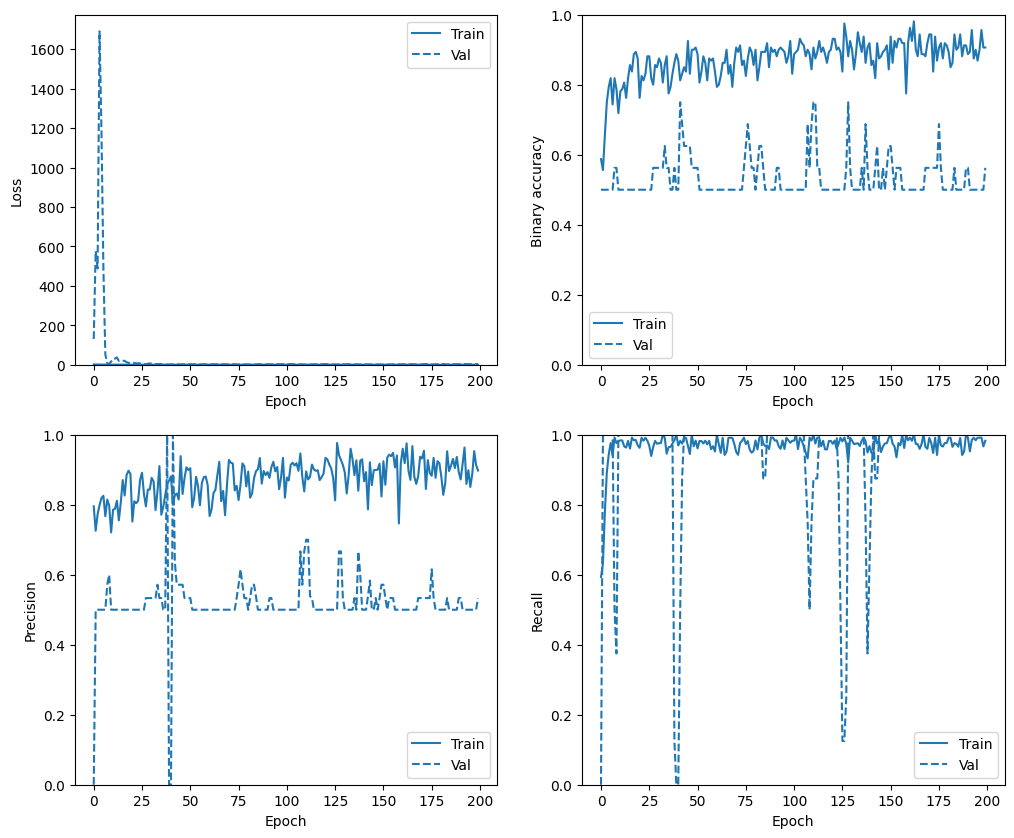

In [20]:
mpl.rcParams['figure.figsize'] = (12, 10)
metrics =  [matrix for matrix in matrix.keys()]
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])
    plt.legend()

In [21]:
model_json = model.to_json() 
with open(r'E:\College\4th year 8th Sem\Project\pneumonia_Detection\Best weight\model.json', "w") as json_file: 
    json_file.write(model_json) 
    model.save(r'./Best weight/model/model.h5')

In [22]:
def reshape_image(path):
    image = cv2.imread(path)
    image = cv2.resize(image,(128,128))
    image = image/255
    image = image.reshape(1,128,128,3)
    return image

In [23]:
path = r"E:\College\4th year 8th Sem\Project\pneumonia_Detection\dataset\chest_xray\test\PNEUMONIA\person1_virus_6.jpeg"
model.predict(reshape_image(path))

1/1 [==============================] - 0s 372ms/step


array([[0.9995826]], dtype=float32)

In [24]:
json_file = open(r'./Best weight/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights(r'./Best weight/weight.h5')
loaded1_model = load_model(r'./Best weight/model/model.h5',compile=False)

In [25]:
path = r'E:\College\4th year 8th Sem\Project\pneumonia_Detection\dataset\chest_xray\test\PNEUMONIA\person1_virus_6.jpeg'
loaded1_model.predict(reshape_image(path)),loaded_model.predict(reshape_image(path))

1/1 [==============================] - 0s 235ms/step


(array([[0.9995826]], dtype=float32), array([[0.8438222]], dtype=float32))